## Model evaluation

In [ ]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode
using Random

In [ ]:
using Revise
using TokenizersLite
using TransformersLite

In [ ]:
includet("reporting.jl")
includet("training.jl")

## Load data

raw

In [ ]:
path = "path\\to\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [ ]:
checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [ ]:
nrow(df)

200000

transformed

In [ ]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


test

In [ ]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


models

In [ ]:
directory = "../outputs/20220519_1535"

saved_objects = BSON.load(joinpath(directory, "model.bson"))

Dict{Symbol, Any} with 3 entries:
  :tokenizer => BytePairEncoder{String}(length(rules)=8000, length(cache)=0, un…
  :indexer   => IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])
  :model     => TransformerClassifier{Embed{Matrix{Float32}}, PositionEncoding{…

In [ ]:
add_position_encoding(x) = x .+ PositionEncoding(32)(x) 

add_position_encoding (generic function with 1 method)

In [ ]:
@show tokenizer = saved_objects[:tokenizer]
@show indexer = saved_objects[:indexer]
model = saved_objects[:model]
display(model)

tokenizer = saved_objects[:tokenizer] = BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])
indexer = saved_objects[:indexer] = IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])


TransformerClassifier(
  Embed((32, 7455)),                    # 238_560 parameters
  PositionEncoding(32),
  Dropout(0.1),
  TransformerEncoderBlock(
    MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
      denseQ = Dense(32 => 32),         # 1_056 parameters
      denseK = Dense(32 => 32),         # 1_056 parameters
      denseV = Dense(32 => 32),         # 1_056 parameters
      denseO = Dense(32 => 32),         # 1_056 parameters
    ),
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
    Dense(32 => 128, relu),             # 4_224 parameters
    Dense(128 => 32),                   # 4_128 parameters
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
  ),
  Dense(32 => 1),                       # 33 parameters
  FlattenLayer(),
  Dense(50 => 1),                       # 51 parameters
)        # Total: 21 trainable arrays, 251_348 parameters,
          # plus 1 non-trainable, 32_000 parameters, summarysize 1.082 MiB.

In [ ]:
max_length = size(model.classifier.weight, 2)

50

## Tokenizers

In [ ]:
function clean(s::AbstractString)
    s = lowercase(s)
    s = Unicode.normalize(s, :NFD)
    s = replace(s, r"['`’\u200d\p{M}]" => "") # contractions, zero width joiner and marks from normalization
    s = replace(s, r"\n" => " ")
end

function preprocess(document, tokenizer; pattern = r"[A-Za-z][A-Za-z]+\b", max_length::Union{Nothing, Int}=nothing)
    document = clean(document)
    words = map(m->string(m.match), eachmatch(pattern, document))
    tokens = tokenizer(words)
    if !isnothing(max_length)
        if length(tokens) > max_length
            tokens = tokens[1:max_length]
        end
    end
    tokens
end

preprocess (generic function with 1 method)

In [ ]:
@time tokens = map(d->preprocess(d, tokenizer, max_length=max_length), documents)
@time indices = indexer(tokens) 

y_train = copy(labels)
y_train[labels .≤ 2] .= 0
y_train[labels .≥ 4] .= 1
idxs = labels .!= 3
X_train, y_train = indices[:, idxs], y_train[idxs];
y_train = reshape(y_train, 1, :)
train_data, val_data = split_validation(X_train, y_train; rng=MersenneTwister(2718))

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

 61.007151 seconds (654.73 M allocations: 20.558 GiB, 9.15% gc time, 1.03% compilation time)
 23.645726 seconds (133.27 k allocations: 84.891 MiB, 0.43% compilation time)
train samples:      (50, 144000) (1, 144000)
validation samples: (50, 16000) (1, 16000)


In [ ]:
y_test = copy(labels_test)
y_test[labels_test .≤ 2] .= 0
y_test[labels_test .≥ 4] .= 1
idxs = labels_test .!= 3
y_test = reshape(y_test[idxs], 1, :);

@time tokens_test = map(d->preprocess(d, tokenizer, max_length=max_length), documents_test) 
@time indices_test = indexer(tokens_test)

X_test = indices_test[:, idxs]

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  0.648366 seconds (6.00 M allocations: 210.076 MiB, 4.83% gc time, 14.18% compilation time)
  0.519239 seconds (4 allocations: 1.946 MiB)
test indices: (50, 5000)
test samples: (50, 4000) (1, 4000)


In [ ]:
train_data_loader = DataLoader(train_data; batchsize=32, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=32, shuffle=false);

## Evaluate

In [ ]:
loss(x, y) = Flux.logitbinarycrossentropy(model(x), y)
loss(x::Tuple) = loss(x[1], x[2])
accuracy(ŷ, y) = mean((Flux.sigmoid.(ŷ) .> 0.5) .== y)

accuracy (generic function with 1 method)

In [ ]:
@time batched_metric(accuracy, train_data_loader, g=model)

 70.271698 seconds (38.20 M allocations: 46.020 GiB, 8.88% gc time, 21.87% compilation time)


0.9039930555555555

In [ ]:
@time batched_metric(accuracy, val_data_loader, g=model)

  5.508031 seconds (97.00 k allocations: 4.895 GiB, 8.80% gc time)


0.878125

In [ ]:
history = Dict()
open(joinpath(directory, "history.json"), "r") do f
    global history
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[0.396013, 0.330704, 0.304764, 0.289531, 0.274037, 0.26764…
  "train_acc"  => Any[0.819701, 0.857681, 0.870917, 0.87775, 0.884451, 0.888771…
  "val_acc"    => Any[0.81525, 0.848938, 0.860375, 0.8675, 0.869813, 0.873563, …
  "val_loss"   => Any[0.401629, 0.342548, 0.31801, 0.309395, 0.30046, 0.300756,…

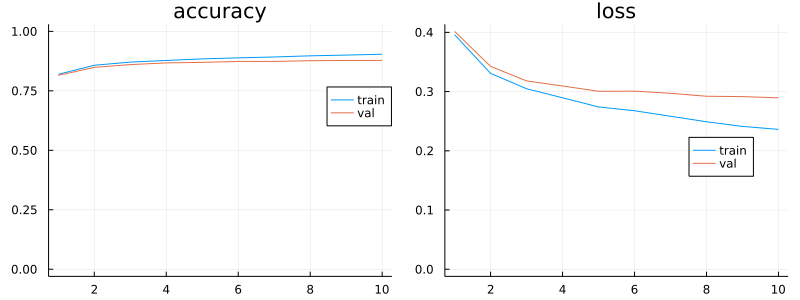

In [ ]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.7))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(directory, "history.png"))
p

## Test data

In [ ]:
logits = model(X_test)
accuracy(logits, y_test)

0.87475

In [ ]:
probs = σ.(logits)
y_pred = Int.(probs .> 0.5);

In [ ]:
cm = confusion_matrix(vec(y_pred), vec(y_test), 0:1)

2×2 Matrix{Int64}:
 1777   223
  278  1722

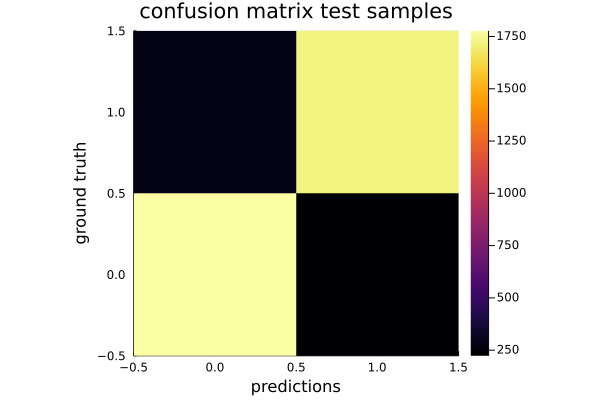

In [ ]:
p = heatmap(0:1, 0:1, cm, xlabel="predictions", ylabel="ground truth", xlims=(-0.5,1.5), aspectratio=1, 
    title="confusion matrix test samples")
savefig(p, joinpath(directory, "confusion_matrix_classification.png"))
p

In [ ]:
classification_report(cm, 0:1)

              precision  recall  f1-score  support
           0       0.86    0.89      0.88     2000
           1       0.89    0.86      0.87     2000

weighted avg       0.88    0.87      0.87     4000

2000
2000


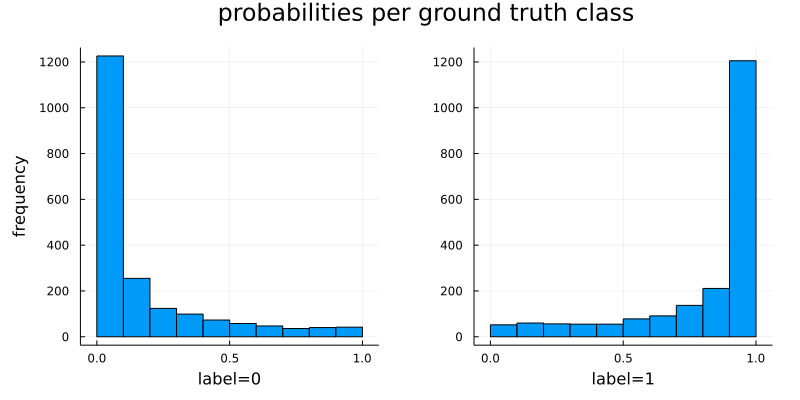

In [ ]:
p = plot()
canvases = []
for label in 0:1
    idxs = y_test .== label
    println(count(idxs))
    c = histogram(probs[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="label=$label", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 2), link=:y, size=(800, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_ground_truth.png"))
p

In [ ]:
nshow = 3

for label in [0, 1]
    println("\ntrue label = $label")
    idxs = y_test .== label
    idxs_label = (1:size(y_test, 2))[vec(idxs)]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    println("#incorrect $(length(idxs_wrong))")
    println(" idx  y  ŷ    prob  ")
    for idx in sample(idxs_wrong, nshow, replace=false)
        @printf("%4d  %d  %d  %.4f  %s\n",
            idx, y_test[idx], y_pred[idx], probs[idx], documents_test[labels_test.!==3][idx]
        )
    end
end


true label = 0
#incorrect 223
 idx  y  ŷ    prob  
1517  0  1  0.8242  Very tight fit in the fingers. Hand fit is good. Never have had to wear a workout glove larger than a large.
1100  0  1  0.8294  This book seems charming and I was curious to see how things played out. However, the theme of leaving and cheating on your spouse as a viable option bothers me greatly.
 688  0  1  0.5175  Yeah it’s great to have a remote for PS Vue but every time you go to use it you have to press either the TV or PS4 button. More irritating than helpful. Such a buzz kill.

true label = 1
#incorrect 278
 idx  y  ŷ    prob  
3328  1  0  0.4378  Such a cute pair of sunglasses!! Thank you so much!
2099  1  0  0.0516  This item is smaller than I thought it would be but it works great!
2435  1  0  0.2108  I'm still trying to remember why I liked Age of Myth, the first novel in this series. Whatever that was, it wasn't really present in the sequel. Though some of the characters are engaging and the overall st

## Test data including star=3

In [ ]:
probs_all = σ.(model(indices_test));
y_pred_all = Int.(probs_all .> 0.5);

In [ ]:
pos_max = argmax(probs_all)[2]
pos_min = argmin(probs_all)[2]

println(" idx  y  ŷ    prob  ")
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_max, labels_test[pos_max], y_pred_all[pos_max], probs_all[pos_max], documents_test[pos_max]
)
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_min, labels_test[pos_min], y_pred_all[pos_min], probs_all[pos_min], documents_test[pos_min]
)

 idx  y  ŷ    prob  
4164  5  1  0.9999  Love it exactly what I needed good quality
 935  1  0  0.0001  Crap! Totally not worth a penny.


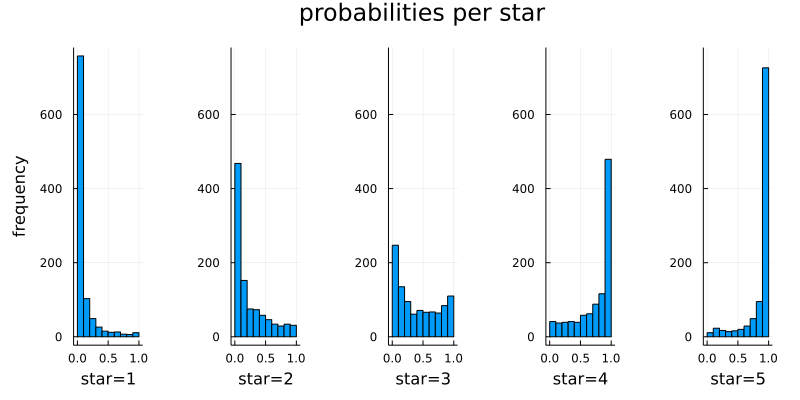

In [ ]:
p = plot()
canvases = []
for star in 1:5
    idxs = labels_test .== star
    c = histogram(probs_all[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="star=$star", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 5), link=:y, size=(800, 400), plot_title="probabilities per star",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_star.png"))
p

In [ ]:
nshow = 3

star = 5
threshold = 0.2
println("star = $star")
idxs = labels_test .== star
idxs_label = (1:length(labels_test))[vec(idxs)]
idxs_wrong = idxs_label[probs_all[idxs] .<= threshold]
println("#incorrect $(length(idxs_wrong))")
println(" idx  y  ŷ    prob  ")
for idx in sample(idxs_wrong, nshow, replace=false)
    @printf("%4d  %d  %d  %.4f  %s\n",
    idx, labels_test[idx], y_pred_all[idx], probs_all[idx], documents_test[idx]
    )
end

println("")
star = 1
threshold = 0.8
println("star = $star")
idxs = labels_test .== star
idxs_label = (1:length(labels_test))[vec(idxs)]
idxs_wrong = idxs_label[probs_all[idxs] .>= threshold]
println("#incorrect $(length(idxs_wrong))")
println(" idx  y  ŷ    prob  ")
for idx in sample(idxs_wrong, nshow, replace=false)
    @printf("%4d  %d  %d  %.4f  %s\n",
    idx, labels_test[idx], y_pred_all[idx], probs_all[idx], documents_test[idx]
    )
end

star = 5
#incorrect 34
 idx  y  ŷ    prob  
4433  5  0  0.1151  The product covered was a wireless mic receiver and transmitter. I covered ith with square trade for three years. After 1 1/2 years of use the product stopped working. I contacted square trade and within 24 hours my claim was duly attended to my satisfaction.
4980  5  0  0.1533  never really knew if an acrylic platter could change the sound. but apparently it does
4474  5  0  0.1103  Worked with the torch. Blue flame. It burned hot enough to destroy aluminum foil

star = 1
#incorrect 17
 idx  y  ŷ    prob  
  51  1  1  0.9044  I have been using this for several years and recently bought several only to find out that they all have perfume in them now.
 768  1  1  0.8849  I'm sure its a lovely book.. Purchased this as a Christmas gift for my nephew. Not very please with the looks of it.
 837  1  1  0.8256  This product is great when it works, which is RARELY. We have attempted to record multiple soccer games and lacrosse gam

## Single samples

In [ ]:
idx = 4700  

d = documents_test[idx]
println(labels_test[idx])
println(d)
tokens = preprocess(d, tokenizer, max_length=50)
println(join(tokens, "|"))
x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
This makes almost the whole series. Roman Nights will be the last one. Loved them all. Alaskan Nights was awesome. Met my expectations , hot SEAL hero, beautiful & feisty woman. Filled with intrigue, steamy romance & nail biting ending. Have read two other books of yours. Am looking forward to more.
⋅this|⋅makes|⋅almost|⋅the|⋅whole|⋅series|⋅rom|##an|⋅nights|⋅will|⋅be|⋅the|⋅last|⋅one|⋅loved|⋅them|⋅all|⋅al|##ask|##an|⋅nights|⋅was|⋅awesome|⋅met|⋅my|⋅expectations|⋅hot|⋅seal|⋅hero|⋅beautiful|⋅fe|##ist|##y|⋅woman|⋅filled|⋅with|⋅intrig|##ue|⋅stea|##my|⋅romance|⋅nail|⋅bit|##ing|⋅ending|⋅have|⋅read|⋅two|⋅other|⋅books
8|242|306|2|475|633|5068|985|2849|44|28|2|167|27|235|32|37|1647|6812|985|2849|14|476|2962|11|1759|403|831|3469|347|2966|1578|269|1998|1521|17|4949|3152|4805|3813|2152|1626|137|124|1537|18|175|106|79|553


In [ ]:
model.embed(x)

32×50 Matrix{Float32}:
  0.451905   -1.0538      0.171775   -2.91452     …  -0.579087    1.3963
 -0.792829    0.193514    0.460786   -0.650348       -0.326142   -0.420839
  0.886454   -0.0081291   1.37228    -0.622589        0.02159    -1.45605
  1.07562    -0.335118    1.47725    -1.09103        -1.43966     0.0748104
 -1.04559     1.16735    -0.711741   -0.993145       -2.06097    -0.987164
 -0.127467    1.04049     0.437017   -0.562423    …  -0.322139    0.335007
  0.12975     1.50486    -0.523657   -0.303724       -1.9308      0.304879
  1.13668     0.520456   -0.38724    -0.518437       -1.22686     0.407064
 -1.0201     -0.873765   -1.04285     0.470348        0.271599    0.925617
  0.551469    0.333771    1.50101    -0.451581       -0.347111    0.110244
  1.15174    -0.524977    1.33581    -0.420894    …  -0.480322   -0.155288
 -0.164869    1.63906     2.26624     0.00807137      0.0463646   0.363379
 -0.0905868   0.363127   -1.17672     0.330325        0.208343   -1.63416
  ⋮  

In [ ]:
σ.(model(x))

1×1 Matrix{Float32}:
 0.9892966